In [1]:
import tensorflow as  tf
from tensorflow import keras
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D,Dropout,MaxPooling1D,Activation,Flatten,Dense
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [2]:
test_path=os.path.join(os.getcwd(),"data")
test_path

'C:\\Users\\Sharath\\Desktop\\stuff\\projects\\proj\\data'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
cmap=plt.cm.Blues
title='Confusion matrix'
# classes = Le.classes_
normalize=False
figname = 'model3.jpg'

def plot_confusion_matrix(cm, classes, figname, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print("Confusion matrix, without normalization")
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
 #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
#         plt.savefig(figname)

This function takes Actor directory as input and returns a numpy array of only 4 emotions [Audio_path,gender,emotion]

In [4]:
def prep_labels(Actor_dir):
    emotion=[]
    gender=[]
    audios=[]
    emotion_d={1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
    gender_d={0:'female',1:'male'}
    for actor in os.listdir(Actor_dir):
        file_p=(os.path.join(Actor_dir,actor))
        for recording in os.listdir(file_p):
            if recording[6:-16]in ["02","03","04","05"]:
                emotion.append(int(recording[6:-16]))
                gender.append(int(recording[18:-4])%2)
                audios.append(os.path.join(file_p,recording))
    gender=[gender_d[i] for i in gender]
    emotion=[emotion_d[i] for i in emotion]
    return np.c_[audios,gender,emotion]

This function takes a numpy array of paths and returns a pandas dataframe of Mfcc features and labels

In [5]:
def features(Path,sample_rate=22050*2,offset=0.5,n_mfcc=13,duration=2.5):
    df = pd.DataFrame(columns=['features'])
    count=0
    for f in list(Path):
        X, sample_rate = librosa.load(f, res_type='kaiser_fast',duration=duration,sr=sample_rate,offset=offset)
        mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=n_mfcc).T,axis=0)
        features = mfccs
        df.loc[count] = [features]
        count=count+1
        d=pd.DataFrame(df['features'].values.tolist())
    return d

In [6]:
df_final=features(prep_labels(test_path)[:,0],n_mfcc=40)

In [7]:
df_final["emotion"]=prep_labels(test_path)[:,2]

In [9]:
df_final

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-691.554016,103.488388,6.234205,18.971476,8.451644,18.539339,-6.382955,6.202209,-10.171426,-0.678910,...,-5.225513,-0.647115,-0.530049,-2.785005,0.125315,-1.336625,-2.389767,-0.677985,-2.257579,calm
1,-669.990479,111.411613,10.758529,15.129254,8.621660,20.590872,-5.424139,4.473267,-9.863037,-1.271303,...,-4.514940,-1.264935,-1.201889,-2.088279,-0.541381,-2.506760,-3.407242,-2.235733,-3.555218,calm
2,-660.321472,111.567696,4.625660,19.650215,6.706089,18.305843,-6.093471,10.697109,-10.637363,0.421806,...,-5.643905,-0.768427,-0.937701,-3.438322,-0.336898,-2.816852,-2.498607,-1.849675,-2.227733,calm
3,-663.058350,111.353386,6.952808,16.100903,8.186879,18.408474,-6.693346,9.646807,-11.229571,-1.220288,...,-4.297531,-1.210608,-1.576615,-3.309341,-0.375529,-2.907807,-3.097103,-0.968241,-2.492663,calm
4,-680.847107,121.460922,10.062194,21.828939,7.593652,24.082800,-7.907874,8.599798,-12.025018,4.583032,...,-3.877761,0.625304,-2.025431,-2.090710,-0.976551,-2.383626,-3.999593,-3.170493,-2.492446,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-444.119110,73.669128,-28.460447,5.365310,-13.476593,-2.534122,-30.909962,-3.104536,-14.926821,-13.822457,...,3.538071,7.758658,10.049922,6.853305,7.994804,10.021395,4.083268,3.643723,0.631288,angry
764,-378.511078,64.218536,-32.865643,11.794813,-10.838286,-13.677436,-26.487675,1.482656,-14.414303,-12.062708,...,6.069856,4.045506,2.930989,-0.176050,-0.430975,0.593558,-0.287489,2.036106,0.191679,angry
765,-415.127319,68.543427,-34.881615,10.059309,-12.314293,-7.163306,-27.360477,2.133626,-14.272416,-12.633283,...,9.127749,5.921012,1.140636,1.266077,-0.284112,3.392887,1.678638,0.742106,-0.852997,angry
766,-440.400391,73.256340,-24.545799,10.807652,-14.200200,-3.927950,-24.290613,-3.342228,-17.595304,-11.925268,...,3.089315,6.614276,10.623822,9.390310,10.567907,9.109989,3.990542,1.412750,-1.220157,angry


In [10]:
df_final

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-691.554016,103.488388,6.234205,18.971476,8.451644,18.539339,-6.382955,6.202209,-10.171426,-0.678910,...,-5.225513,-0.647115,-0.530049,-2.785005,0.125315,-1.336625,-2.389767,-0.677985,-2.257579,calm
1,-669.990479,111.411613,10.758529,15.129254,8.621660,20.590872,-5.424139,4.473267,-9.863037,-1.271303,...,-4.514940,-1.264935,-1.201889,-2.088279,-0.541381,-2.506760,-3.407242,-2.235733,-3.555218,calm
2,-660.321472,111.567696,4.625660,19.650215,6.706089,18.305843,-6.093471,10.697109,-10.637363,0.421806,...,-5.643905,-0.768427,-0.937701,-3.438322,-0.336898,-2.816852,-2.498607,-1.849675,-2.227733,calm
3,-663.058350,111.353386,6.952808,16.100903,8.186879,18.408474,-6.693346,9.646807,-11.229571,-1.220288,...,-4.297531,-1.210608,-1.576615,-3.309341,-0.375529,-2.907807,-3.097103,-0.968241,-2.492663,calm
4,-680.847107,121.460922,10.062194,21.828939,7.593652,24.082800,-7.907874,8.599798,-12.025018,4.583032,...,-3.877761,0.625304,-2.025431,-2.090710,-0.976551,-2.383626,-3.999593,-3.170493,-2.492446,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-444.119110,73.669128,-28.460447,5.365310,-13.476593,-2.534122,-30.909962,-3.104536,-14.926821,-13.822457,...,3.538071,7.758658,10.049922,6.853305,7.994804,10.021395,4.083268,3.643723,0.631288,angry
764,-378.511078,64.218536,-32.865643,11.794813,-10.838286,-13.677436,-26.487675,1.482656,-14.414303,-12.062708,...,6.069856,4.045506,2.930989,-0.176050,-0.430975,0.593558,-0.287489,2.036106,0.191679,angry
765,-415.127319,68.543427,-34.881615,10.059309,-12.314293,-7.163306,-27.360477,2.133626,-14.272416,-12.633283,...,9.127749,5.921012,1.140636,1.266077,-0.284112,3.392887,1.678638,0.742106,-0.852997,angry
766,-440.400391,73.256340,-24.545799,10.807652,-14.200200,-3.927950,-24.290613,-3.342228,-17.595304,-11.925268,...,3.089315,6.614276,10.623822,9.390310,10.567907,9.109989,3.990542,1.412750,-1.220157,angry


In [11]:
 X_train, X_test, y_train, y_test = train_test_split(df_final.iloc[:,:-1],df_final.iloc[:,-1], test_size=0.33, random_state=42)

In [27]:
Le=LabelEncoder()
Le.fit(df_final["emotion"])
Le.classes_

array(['angry', 'calm', 'happy', 'sad'], dtype=object)

In [13]:
y_train=Le.transform(y_train)
y_test=Le.transform(y_test)

In [14]:
dtc = DecisionTreeClassifier()


In [15]:
dtc.fit(X_train, y_train)


DecisionTreeClassifier()

In [16]:
predictions = dtc.predict(X_test)


Confusion matrix, without normalization


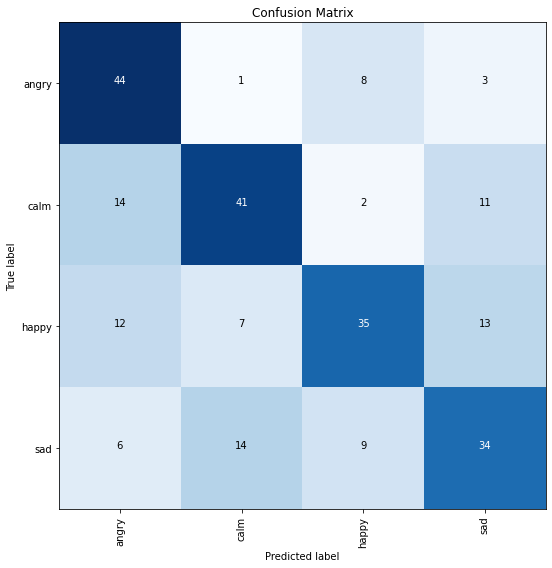

In [17]:
cm = confusion_matrix( y_test,predictions)
plot_confusion_matrix(cm, classes = Le.classes_, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete2.jpg')

In [18]:
print(classification_report(y_test,predictions,target_names=Le.classes_))

              precision    recall  f1-score   support

       angry       0.58      0.79      0.67        56
        calm       0.65      0.60      0.63        68
       happy       0.65      0.52      0.58        67
         sad       0.56      0.54      0.55        63

    accuracy                           0.61       254
   macro avg       0.61      0.61      0.60       254
weighted avg       0.61      0.61      0.60       254



In [19]:
rfc = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)
rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [20]:
predictions = rfc.predict(X_test)

In [21]:
print(classification_report(y_test,predictions,target_names=Le.classes_))

              precision    recall  f1-score   support

       angry       0.71      0.95      0.81        56
        calm       0.67      0.84      0.75        68
       happy       0.65      0.45      0.53        67
         sad       0.60      0.46      0.52        63

    accuracy                           0.67       254
   macro avg       0.66      0.67      0.65       254
weighted avg       0.66      0.67      0.65       254



Confusion matrix, without normalization


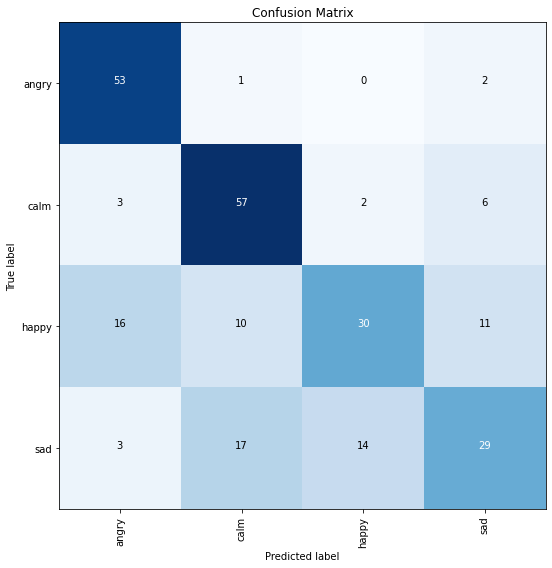

In [22]:
cm = confusion_matrix( y_test,predictions)
plot_confusion_matrix(cm, classes = Le.classes_, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete2.jpg')

In [29]:
import pickle
pickle.dump(rfc, open('rfc.pkl','wb'))


In [28]:
joblib_file = "dtc.pkl"  

joblib.dump(dtc, joblib_file)

['dtc.pkl']

In [27]:
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
model = keras.models.Sequential()
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [31]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_3 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_4 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 128)           

In [35]:
%load_ext tensorboard

In [32]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [66]:
import datetime
log_dir = "model_board_1" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [67]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [68]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test),callbacks=[tensorboard_callback])


Epoch 1/1000
33/33 [==============================] - 0s 11ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 1.1738 - val_accuracy: 0.7835
Epoch 2/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.0084 - accuracy: 0.9981 - val_loss: 1.1938 - val_accuracy: 0.7835
Epoch 3/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.0097 - accuracy: 0.9981 - val_loss: 1.0462 - val_accuracy: 0.7992
Epoch 4/1000
33/33 [==============================] - 0s 6ms/step - loss: 0.0133 - accuracy: 0.9961 - val_loss: 1.1103 - val_accuracy: 0.7874
Epoch 5/1000
33/33 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 1.1209 - val_accuracy: 0.7992
Epoch 6/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.0266 - accuracy: 0.9922 - val_loss: 1.2316 - val_accuracy: 0.7677
Epoch 7/1000
33/33 [==============================] - 0s 7ms/step - loss: 0.0097 - accuracy: 0.9961 - val_loss: 1.0872 - val_accuracy: 0.7992
Epoch

In [70]:
%tensorboard --logdir model_board_1


<AxesSubplot:>

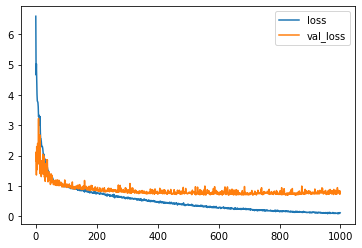

In [42]:
pd.DataFrame(cnnhistory.history)[["loss","val_loss"]].plot()

<AxesSubplot:>

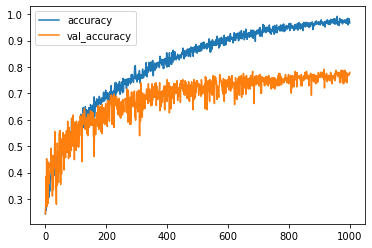

In [43]:
pd.DataFrame(cnnhistory.history)[["accuracy","val_accuracy"]].plot()

In [45]:
predictions=model.predict_classes(x_testcnn)

Confusion matrix, without normalization


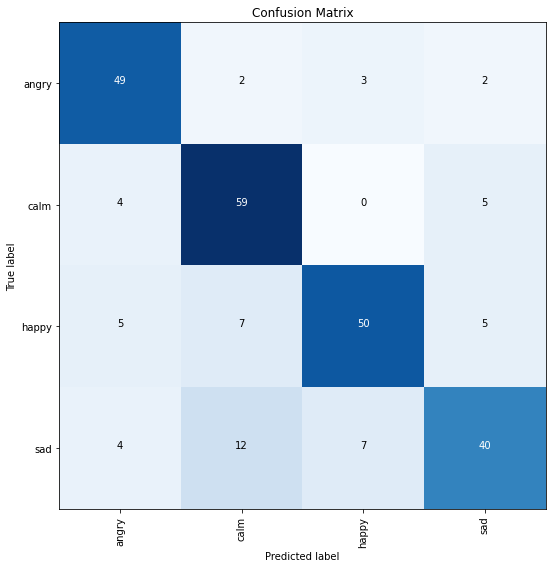

In [46]:
cm = confusion_matrix( y_test,predictions)
plot_confusion_matrix(cm, classes = Le.classes_, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete2.jpg')

In [47]:
print(classification_report(y_test,predictions,target_names=Le.classes_))

              precision    recall  f1-score   support

       angry       0.79      0.88      0.83        56
        calm       0.74      0.87      0.80        68
       happy       0.83      0.75      0.79        67
         sad       0.77      0.63      0.70        63

    accuracy                           0.78       254
   macro avg       0.78      0.78      0.78       254
weighted avg       0.78      0.78      0.78       254

